In this notebook, we show the example of doing LOGAN based on the $RACE$ attribute. You can change the corresponding attribute.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
import os

In [3]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import utils

In [4]:
from sklearn import metrics
from collections import Counter

In [5]:
from nltk.tokenize import  word_tokenize
from collections import defaultdict
from sklearn.metrics import confusion_matrix

- ### Section 1: Load the predictions and sentence embeddings

We already save the predictions to the csv file and save the sentence embeddings from the second last layer of a vanilla BERT model. We use the sentence embeddings for clustering. 

- *You can change the feature used here for clustering*

In [6]:
test_file = './pred_test_bw_withpredscores.csv'
res = pd.read_csv(test_file, index_col=0)

In [7]:
#cluster based on sentence embeddings
test_embs = np.load('/local/jyzhao/Github/disentanglement/second2last_mean.npy')
print(f"test embedding shape:{test_embs.shape}")

test embedding shape:(97320, 768)


In [8]:
#read the original test dataset
data_dir = '/home/jyzhao/git/data/jigsawUnintendedBiasinToxicityClassification'
test_df = pd.read_csv(os.path.join(data_dir,"test_public_expanded.csv"))

In [9]:
test_df[:1]

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,NaN,164149,approved,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
res.columns

Index(['id', 'comment_text', 'created_date', 'publication_id', 'parent_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'identity_annotator_count',
       'toxicity_annotator_count', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'target', 'preds', 'pred_score'],
      dtype='object')

- Here, we consider two race groups, 'black' and 'white'. You can change this by choosing the corresponding groups shown above, e.g. 
> ta, tb = 'female', 'male'

In [11]:
ta, tb = 'white', 'black'
ta_df = res[(res[ta] >= 0.5) & (res[tb] < 0.5)]
tb_df = res[(res[tb] >= 0.5) & (res[ta] < 0.5)]
print(f"{len(ta_df)} {ta} examples, {len(tb_df)} {tb} examples")

957 white examples, 441 black examples


In [12]:
ta_acc = len(ta_df[ta_df['preds'] == ta_df['target']])/len(ta_df)
tb_acc = len(tb_df[tb_df['preds'] == tb_df['target']])/len(tb_df)
print(f"acc {ta}:{ta_acc}, {tb}:{tb_acc}, diff:{ta_acc - tb_acc:.4f}")
print(f"overall acc:{len(res[res['preds'] == res['target']])/len(res)}")

acc white:0.8077324973876698, black:0.7596371882086168, diff:0.0481
overall acc:0.9020653514180025


In [13]:
#get all the embeddings related to these two groups
tgs = test_embs[np.concatenate((ta_df.index.values, tb_df.index.values))]
print(tgs.shape)

(1398, 768)


In [14]:
# get all the prediction results regarding to these 2 groups
tgt = pd.concat([ta_df, tb_df], axis = 0)

In [15]:
print(f"for race group, the overall accuracy is {metrics.accuracy_score(y_true = tgt['target'], y_pred = tgt['preds'])}")

for race group, the overall accuracy is 0.7925608011444921


- ### Section 2: visualization of embeddings

In [26]:
tsne = TSNE(n_components=2, verbose=4, perplexity=10, learning_rate=10.0, init='pca')
tsne_results = tsne.fit_transform(tgs)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1398 samples in 0.093s...
[t-SNE] Computed neighbors for 1398 samples in 2.862s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1398
[t-SNE] Computed conditional probabilities for sample 1398 / 1398
[t-SNE] Mean sigma: 1.223635
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 82.6226196, gradient norm = 0.0065150 (50 iterations in 1.776s)
[t-SNE] Iteration 100: error = 82.7579575, gradient norm = 0.0000115 (50 iterations in 1.660s)
[t-SNE] Iteration 150: error = 82.7579422, gradient norm = 0.0000097 (50 iterations in 1.547s)
[t-SNE] Iteration 200: error = 82.7579498, gradient norm = 0.0000112 (50 iterations in 1.615s)
[t-SNE] Iteration 250: error = 82.7579498, gradient norm = 0.0000111 (50 iterations in 1.497s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.757950
[t-SNE] Iteration 300: error = 3.7523510, gradient norm = 0.0049218 (50 iterations in 1.610s)

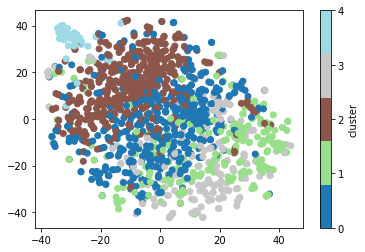

In [28]:
NCluster = 5
kmeans = KMeans(NCluster, random_state=1, n_jobs=20, max_iter = 300, algorithm = 'full').fit(tgs)
utils.plot_clusters(kmeans.labels_, tsne_results, NCluster)

- ### Section 3: Do the clustering

- #### Clustering using vanilla K-Means
We will first cluster examples to a large number of clusters (k=10) and then merge the smallest cluster to its closest center iteratively. Please see "merge_clusters" function.

In [16]:
NCluster = 10
kmeans = KMeans(NCluster, random_state=10, n_jobs=20, precompute_distances = False, algorithm = 'full').fit(tgs)
kmeans_clusters_raw = kmeans.labels_
kcenters = kmeans.cluster_centers_

#calculate #white/black instances in each cluster
gender_c = []
for i in range(NCluster):
    idxc = np.where(kmeans_clusters_raw == i)
    tgtc = tgt.iloc[idxc]
    gender_c.append(np.array([len(tgtc[tgtc[ta] >= 0.5]), len(tgtc[tgtc[tb] >= 0.5])]))
    

#Merge small clusters
g, NCluster, kmeans_clusters = utils.merge_clusters(gender_c, kcenters, kmeans_clusters_raw, tgs)

Done merge for all clusters have at least 20 M/F images


- #### Get the performance of each cluster

In [17]:
res4plot = []
for i in np.unique(kmeans_clusters):
    idxc = np.where(kmeans_clusters == i)
    tgtc = tgt.iloc[idxc]
    tac = tgtc[tgtc[ta] >= 0.5]
    tbc = tgtc[tgtc[tb] >= 0.5]
    accac = metrics.accuracy_score(y_true=tac['target'], y_pred = tac['preds'])
    accbc = metrics.accuracy_score(y_true=tbc['target'], y_pred = tbc['preds'])
    res4plot.append([accac, accbc, abs(accac-accbc)])
    print(f"c {i}, {len(tac)} {ta}, {len(tbc)} {tb}, acc:{accac:.5f}, {accbc: .5f}, acc_d:{accac - accbc:.4f}")

c 0, 112 white, 26 black, acc:0.75893,  0.53846, acc_d:0.2205
c 1, 116 white, 41 black, acc:0.81034,  0.70732, acc_d:0.1030
c 2, 96 white, 53 black, acc:0.84375,  0.67925, acc_d:0.1645
c 3, 128 white, 59 black, acc:0.72656,  0.72881, acc_d:-0.0023
c 4, 128 white, 81 black, acc:0.85156,  0.85185, acc_d:-0.0003
c 5, 192 white, 75 black, acc:0.88021,  0.80000, acc_d:0.0802
c 6, 122 white, 66 black, acc:0.80328,  0.81818, acc_d:-0.0149
c 7, 63 white, 40 black, acc:0.69841,  0.75000, acc_d:-0.0516


In [18]:
from matplotlib import pyplot as plt

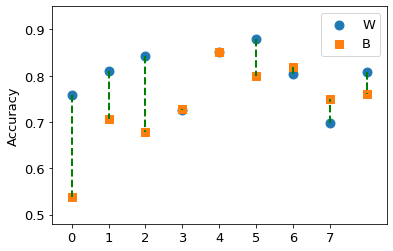

In [19]:
plt.close('all')
plt.rc('font', size=13)  
res4plot.append([ta_acc, tb_acc, abs(ta_acc - tb_acc)])
for i in range(len(res4plot)):
    x = [i, i]
    y = [res4plot[i][0], res4plot[i][1]]
    plt.plot(x, y, '--', color ='green', linewidth=2)
plt.plot([8, 8], [ta_acc, tb_acc], '--', color ='green', linewidth=2)
plt.scatter(range(len(res4plot) ),np.array(res4plot)[:,0], label = 'W', marker ='o', s=80)
plt.scatter(range(len(res4plot)), np.array(res4plot)[:, 1], label = 'B', marker = 's', s=80)
plt.ylabel('Accuracy')
plt.ylim([0.48, 0.95])
plt.xticks(range(len(res4plot) -1))
plt.legend()
plt.savefig('race_acc_gap_kmeans.pdf')
plt.show()

In [20]:
def get_inertia(clusters, embs):
    dis = 0
    for c in np.unique(clusters):
        idxc = np.where(clusters == c)
        centers = np.average(embs[idxc], axis = 0)
        norms =  np.linalg.norm((embs[idxc]- centers), axis = 0)**2
        dis += norms.sum()
    return dis

- #### Do clustering based on LOGAN

In [21]:
from sklearn.cluster import KMeans_logan

In [22]:
#For the variable "atts" here, it is used to differentiate the two groups 
atts = np.concatenate((np.zeros(len(ta_df)), np.ones(len(tb_df))))
attributes = np.stack((tgt['target'], tgt['preds'], atts), axis = -1).astype("float32")

In [23]:
NCluster = 10
ikmeans = KMeans_logan(NCluster, random_state=10, n_jobs = -1, precompute_distances = False, eta= -5, algorithm = 'full').fit(tgs, attributes)
ikmeans_clusters_raw = ikmeans.labels_
ikcenters = ikmeans.cluster_centers_

#calculate #white/black instances in each cluster
igender_c = []
for i in range(NCluster):
    idxc = np.where(ikmeans_clusters_raw == i)
    tgtc = tgt.iloc[idxc]
    igender_c.append(np.array([len(tgtc[tgtc[ta] >= 0.5]), len(tgtc[tgtc[tb] >= 0.5])]))

    #Merge small clusters
ig, iNCluster, ikmeans_clusters = utils.merge_clusters(igender_c, ikcenters, ikmeans_clusters_raw, tgs)

Done merge for all clusters have at least 20 M/F images


In [25]:
res4plot = []
for i in range(iNCluster):
    idxc = np.where(ikmeans_clusters == i)
    tgtc = tgt.iloc[idxc]
    tac = tgtc[tgtc[ta] >= 0.5]
    tbc = tgtc[tgtc[tb] >= 0.5]
    accac = metrics.accuracy_score(y_true=tac['target'], y_pred = tac['preds'])
    accbc = metrics.accuracy_score(y_true=tbc['target'], y_pred = tbc['preds'])
    res4plot.append([accac, accbc, abs(accac - accbc)])
    print(f"c {i}, {len(tac)} {ta}, {len(tbc)} {tb}, acc:{accac:.5f}, {accbc: .5f}, acc_d:{accac - accbc:.4f}")
    
    
inertia_kmeans = get_inertia(kmeans_clusters, tgs)
inertia_ikmeans = get_inertia(ikmeans_clusters, tgs)
print(f"inertia: kmeans{inertia_kmeans}, ikmeans:{inertia_ikmeans}, ratio:{inertia_ikmeans / inertia_kmeans}")

c 0, 103 white, 29 black, acc:0.76699,  0.55172, acc_d:0.2153
c 1, 130 white, 43 black, acc:0.83077,  0.67442, acc_d:0.1564
c 2, 109 white, 56 black, acc:0.85321,  0.71429, acc_d:0.1389
c 3, 62 white, 42 black, acc:0.64516,  0.71429, acc_d:-0.0691
c 4, 142 white, 77 black, acc:0.83803,  0.84416, acc_d:-0.0061
c 5, 246 white, 92 black, acc:0.85772,  0.80435, acc_d:0.0534
c 6, 111 white, 64 black, acc:0.79279,  0.82812, acc_d:-0.0353
c 7, 54 white, 38 black, acc:0.64815,  0.73684, acc_d:-0.0887
inertia: kmeans37574.896728515625, ikmeans:37658.902099609375, ratio:1.0022356780299544


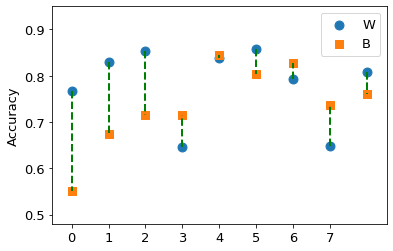

In [26]:
plt.close('all')
plt.rc('font', size=13)  
res4plot.append([ta_acc, tb_acc, abs(ta_acc - tb_acc)])
for i in range(len(res4plot)):
    x = [i, i]
    y = [res4plot[i][0], res4plot[i][1]]
    plt.plot(x, y, '--', color ='green', linewidth=2)
plt.plot([8, 8], [ta_acc, tb_acc], '--', color ='green', linewidth=2)
plt.scatter(range(len(res4plot) ),np.array(res4plot)[:,0], label = 'W', marker ='o', s=80)
plt.scatter(range(len(res4plot)), np.array(res4plot)[:, 1], label = 'B', marker = 's', s=80)
plt.ylabel('Accuracy')
plt.ylim([0.48, 0.95])
plt.xticks(range(len(res4plot) -1))
plt.legend()
plt.savefig('race_acc_gap_logan.pdf')
plt.show()

- ## Section 4: topics in each cluster

In [27]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [28]:
stop = set(stop)
with open('stoplist_final.txt', 'r') as f:
    for s in f.readlines():
        stop.add(s.strip())

In [29]:
tgt['tokenized'] = tgt['comment_text'].apply(lambda x: word_tokenize(x))
tgt['non_stopped'] = tgt['tokenized'].apply(lambda x: [item.lower() for item in x if (item.lower() not in stop and item.isalnum())])

In [33]:
stg = 'racist'
ta_df = tgt[(tgt[ta] >= 0.5) & (tgt[tb] < 0.5)]
tb_df = tgt[(tgt[tb] >= 0.5) & (tgt[ta] < 0.5)]
acc1 = len(ta_df[ta_df['preds'] == ta_df['target']])/len(ta_df)
acc2 = len(tb_df[tb_df['preds'] == tb_df['target']])/len(tb_df)
print(len(ta_df), len(tb_df))
print(f"acc for {ta}: {acc1} , {tb}: {acc2}, diff:{acc1-acc2:.4f}")
t1 = ta_df[ta_df['non_stopped'].apply(lambda x: stg in x)]
t2 = tb_df[tb_df['non_stopped'].apply(lambda x: stg in x)]
print(f"number of examples containing '{stg}' in {ta}: {len(t1)}, in {tb}: {len(t2)}")
acc1 = metrics.accuracy_score(y_true = t1['target'], y_pred = t1['preds'])
acc2 = metrics.accuracy_score(y_true = t2['target'], y_pred = t2['preds'])
print(acc1, acc2 , "diff:", acc1-acc2 )

957 441
acc for white: 0.8077324973876698 , black: 0.7596371882086168, diff:0.0481
number of examples containing 'racist' in white: 104, in black: 33
0.7980769230769231 0.6060606060606061 diff: 0.19201631701631705


### LDA topic model

In [34]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [35]:
np.random.seed(1110)

In [36]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jyzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
def stemming(text):
    stems = []
    for w in text:
        stems.append(PorterStemmer().stem(w))
    return stems

In [38]:
tgt['stem'] = tgt['non_stopped'].map(stemming)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation as LDA

- Read about LDA and the corresponding code from [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

In [41]:
def plot_10_most_common_words(count_data, count_vectorizer):
    
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    plt.bar(x_pos, counts)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [49]:
def print_topics(model, count_vectorizer, topk):
    keywords = set()
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-topk -1: -1]]))
        x = topic.argsort()[:-topk-1 : -1]
        keywords.update(set(x))
    return list(keywords)


- In LOGAN, cluster 0 and 4 have the most and least biased results. Change the ikmeans.labels_ in below function to see the results from those two clusters.

In [54]:
cv = CountVectorizer()
clusterid = 0
count_data = cv.fit_transform(tgt.iloc[np.where(ikmeans.labels_ == clusterid)]['non_stopped'].apply(lambda x: ' '.join(x)))

In [53]:
# plot_10_most_common_words(count_data, cv)

In [55]:
# Tweak the two parameters below
number_topics = 1
topk = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=1100)
lda.fit(count_data)
# Print the topics found by the LDA model
print(f"Topics for cluster {clusterid} found via LDA:")
kws = print_topics(lda, cv, topk)

Topics for cluster 0 found via LDA:

Topic #0:
white trump black supremacist supremacists kkk people party america racist president support vote sessions voters republican said obama man base bannon nationalists fascist groups fact right need country supremacy first


- ### Extra

What's happening in those clusters where the black group has a higher accuracy, for example in cluster 7 & 3?

In [56]:
cv = CountVectorizer()
clusterid = 7
count_data = cv.fit_transform(tgt.iloc[np.where(ikmeans.labels_ == clusterid)]['non_stopped'].apply(lambda x: ' '.join(x)))
number_topics = 1
topk = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=1100)
lda.fit(count_data)
# Print the topics found by the LDA model
print(f"Topics for cluster {clusterid} found via LDA:")
kws = print_topics(lda, cv, topk)

Topics for cluster 7 found via LDA:

Topic #0:
white black nigga work comments global get first feds dmc damn crap conspiracy comes coming helicopters cheese celebration capitulation came cali boys appropriate americans got jawaiian honor reading wondering woman


In [57]:
cv = CountVectorizer()
clusterid = 3
count_data = cv.fit_transform(tgt.iloc[np.where(ikmeans.labels_ == clusterid)]['non_stopped'].apply(lambda x: ' '.join(x)))
number_topics = 1
topk = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, random_state=1100)
lda.fit(count_data)
# Print the topics found by the LDA model
print(f"Topics for cluster {clusterid} found via LDA:")
kws = print_topics(lda, cv, topk)

Topics for cluster 3 found via LDA:

Topic #0:
white black people go usa trump like supremacist take right men old world police another america time get country nfl left city think hate life next see new year blacks
